In [2]:
%load_ext autoreload
%autoreload 2
import feature_extract
import sys
sys.path.append("..")
import torch
import psql_methods as psql
import pickle
import alchemy_methods as alc
from tqdm import tqdm
import numpy as np
from more_itertools import chunked
import pandas as pd
import snob_utils as snob

The goal of this notebook is to evaluate how effective aesthetic dissimilarity is at predicting sale value

In [3]:
df1 = snob.create_snob_df('expanded_images','expanded_features')
df1

Dataset ReturnIndexDataset
    Number of datapoints: 373074
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/expanded_images/val


100%|████████████████████████████████████████| 1184/1184 [00:02<00:00, 429.86it/s]


,Label,Collection,NFT_num,Contract,sale_price,distance
0,0,0-project,102,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.096525,0.490676
1,0,0-project,103,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.038415,0.368442
2,0,0-project,104,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.034688,0.512769
3,0,0-project,106,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.022950,0.542099
4,0,0-project,108,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.035188,0.482177
...,...,...,...,...,...,...
227196,1263,zombieclub-token,6645,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,1.932220,0.659015
227197,1263,zombieclub-token,6651,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,2.271000,0.560017
227198,1263,zombieclub-token,956,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,2.770620,0.609922
227199,1263,zombieclub-token,958,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,2.407260,0.637645


In [4]:
df2 = snob.create_snob_df('images','features')


Dataset ReturnIndexDataset
    Number of datapoints: 846346
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images/val


100%|████████████████████████████████████████| 1265/1265 [00:02<00:00, 430.53it/s]


In [5]:
command = "select distinct slug from slug_to_type where type='pfps'"
rows = psql.execute_commands([command])
rows = [x[0] for x in rows]
print(len(rows))

4221


In [6]:
total_df =pd.concat([df1, df2], ignore_index=True)
total_df

,Label,Collection,NFT_num,Contract,sale_price,distance
0,0,0-project,102,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.096525,0.490676
1,0,0-project,103,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.038415,0.368442
2,0,0-project,104,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.034688,0.512769
3,0,0-project,106,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.022950,0.542099
4,0,0-project,108,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.035188,0.482177
...,...,...,...,...,...,...
468618,3428,zombieclub-token,6614,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,1.534742,0.612652
468619,3428,zombieclub-token,6628,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,2.425428,0.712623
468620,3428,zombieclub-token,6640,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,1.253140,0.687746
468621,3428,zombieclub-token,969,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,2.493558,0.618565


In [ ]:
command = "Select contract,token_id,rank from nft_to_rarity_2"
rarities = psql.execute_commands([command])

# print(rarities)
# Column names for the DataFrame

columns = ['Contract', 'NFT_num', 'rarity_rank']
# Create a DataFrame from the list of tuples
df_rare = pd.DataFrame(rarities, columns=columns)
merged_df_rare = pd.merge(df_rare, total_df, on=['Contract','NFT_num'])

In [8]:
merged_df = pd.merge(total_df, df_rare, on=columns_to_compare, how='outer', indicator=True)

# Filter rows that are only in df1
coll_to_rare = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
coll_to_rare = coll_to_rare.groupby('Collection').filter(lambda group: len(group) >= 100)
coll_to_rare['Collection'].value_counts()

NameError: name 'df_rare' is not defined

  0%|                                                    | 0/1265 [00:00<?, ?it/s]/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 12%|████▉                                    | 153/1265 [00:00<00:01, 787.38it/s]

Collection: 0xapes-trilogy, Correlation: 0.1447800918783596, P-Value:0.0009843014819011014
Collection: 2545bygr4y, Correlation: 0.2461209991006064, P-Value:0.0001427018162294507
Collection: 3l3phants-official, Correlation: 0.28497539686385676, P-Value:4.479243226606441e-06
Collection: 8bituniverse, Correlation: 0.3250175525890116, P-Value:1.337735628272056e-10
Collection: 8pes-dvnci, Correlation: 0.18312921692015202, P-Value:1.2277883494050162e-05
Collection: 8sian-main-collection, Correlation: 0.20626667820946784, P-Value:6.241109732483733e-06
Collection: akc, Correlation: 0.2329380238050589, P-Value:3.7686924695964404e-08
Collection: akidcalledbeast, Correlation: 0.1594224797227827, P-Value:0.0005911326660191867
Collection: akumu-dragonz, Correlation: 0.12729700817635092, P-Value:0.013133826431337063
Collection: akutars, Correlation: 0.13670273040014225, P-Value:0.030376778159757135
Collection: alienfrensnft, Correlation: 0.09150637179568798, P-Value:0.030675684756005753
Collection: 

 27%|███████████                              | 342/1265 [00:00<00:01, 892.02it/s]

Collection: buttheads-real, Correlation: 0.16047227840282616, P-Value:0.006631709656534166
Collection: camelsnftio, Correlation: 0.10021427900505987, P-Value:0.04008896722823258
Collection: cartoonsnft, Correlation: 0.264544797713731, P-Value:2.93739046251529e-09
Collection: castle-kid-colin-tilley, Correlation: 0.11504409791489631, P-Value:0.020415077217025828
Collection: casual-sloths-official, Correlation: 0.104790675970556, P-Value:0.016828699610020755
Collection: catbloxgenesis, Correlation: 0.21692916739276233, P-Value:1.4899336913155323e-06
Collection: catbloxpumacapsule, Correlation: 0.26378379561683724, P-Value:1.8100818540541806e-07
Collection: catc, Correlation: 0.3002869448604096, P-Value:1.3898494293360771e-06
Collection: cerealclub, Correlation: 0.2710129596985372, P-Value:8.692307887460384e-08
Collection: chain-runners-nft, Correlation: 0.12595434131200953, P-Value:0.010591392503897172
Collection: chaoscityresidents, Correlation: 0.18903985904325427, P-Value:5.2448878264

 43%|█████████████████▌                       | 542/1265 [00:00<00:00, 947.69it/s]

Collection: divineanarchy, Correlation: 0.11431245053527128, P-Value:0.01084069941944033
Collection: doadz, Correlation: 0.15124396840324789, P-Value:0.002819620755747219
Collection: dodofrensxyz, Correlation: 0.3039429227629261, P-Value:4.8082880593112354e-09
Collection: dogeclub-dogc, Correlation: 0.16294395890372787, P-Value:0.00020429180680740967
Collection: dogs-unchained, Correlation: 0.26071257173913737, P-Value:1.3273983274613332e-05
Collection: doodle-apes-society-das, Correlation: 0.1412277923376367, P-Value:0.006507890892285733
Collection: doodlefrensnft, Correlation: 0.17594812872185306, P-Value:0.001809968136082569
Collection: doodles-official, Correlation: 0.3336055178571356, P-Value:3.230033971335644e-15
Collection: doomers-degen-den, Correlation: 0.1885579592671693, P-Value:0.0037921976712669324
Collection: dourdarcels, Correlation: 0.09098294004192242, P-Value:0.042409823935680956
Collection: dr-ethvils-3d-frankenpunks, Correlation: 0.17576781702251634, P-Value:8.30800

 61%|████████████████████████▎               | 769/1265 [00:00<00:00, 1040.66it/s]

Collection: himalayainc, Correlation: 0.30275107309888305, P-Value:1.3784016059635085e-10
Collection: hot-dougs, Correlation: 0.27693675079854485, P-Value:1.8149137301077718e-06
Collection: howlerz, Correlation: 0.09962982505024066, P-Value:0.019549033444331267
Collection: idamura-xyz, Correlation: 0.13675327779441002, P-Value:0.022573094323685053
Collection: imps-by-supernfty, Correlation: 0.19364815631419297, P-Value:0.00017837199140362603
Collection: inbetweeners, Correlation: 0.197598270764618, P-Value:4.6435457473917396e-05
Collection: incognito-nft, Correlation: 0.13442370564830836, P-Value:0.001964404943778392
Collection: infamous-clearance-passes, Correlation: 0.6634836298948943, P-Value:6.39385902005169e-70
Collection: internet-raised-official, Correlation: 0.12532074683777913, P-Value:0.02119172519310039
Collection: invazers, Correlation: 0.41410352893740127, P-Value:1.514425853263908e-05
Collection: invisiblefriends, Correlation: 0.13095892001995887, P-Value:0.00450040151997

 80%|███████████████████████████████        | 1007/1265 [00:01<00:00, 1118.91it/s]

Collection: murakami-flowers-2022-official, Correlation: 0.3087131103929568, P-Value:5.051987843119961e-08
Collection: muribyfabrik, Correlation: 0.15960247137034503, P-Value:0.00029202590425665676
Collection: mutant-hound-collars, Correlation: 0.8895313539976035, P-Value:7.495812038843338e-155
Collection: mysticsuniverse, Correlation: 0.13135763477476908, P-Value:0.047574712412736746
Collection: nakamigos, Correlation: 0.09296498615083523, P-Value:0.03015817679638883
Collection: neopunkssaga, Correlation: 0.23599707091708427, P-Value:3.2293458764536685e-05
Collection: nounpunks-eth, Correlation: 0.2212942569709156, P-Value:2.631876817275739e-06
Collection: nyolings, Correlation: 0.10820985892692524, P-Value:0.008985882188597303
Collection: obitsofficial, Correlation: 0.09997831960582892, P-Value:0.021707098568597875
Collection: official-moar-by-joan-cornella, Correlation: 0.212452681023813, P-Value:2.6506497311346636e-06
Collection: official-surreals, Correlation: 0.1463376924822041, 

100%|███████████████████████████████████████| 1265/1265 [00:01<00:00, 1000.75it/s]

Collection: soynft, Correlation: 0.20810595939667154, P-Value:1.969260326340126e-05
Collection: spaceboysnft, Correlation: 0.1097256111502901, P-Value:0.02335531254188182
Collection: spaceridersnft, Correlation: 0.14534832962349536, P-Value:0.0009838240790808422
Collection: sphpp, Correlation: 0.14676770592405058, P-Value:0.002174078927053016
Collection: spookies-nft, Correlation: 0.2322209660166619, P-Value:8.767437845941525e-06
Collection: ssr-wives, Correlation: 0.1682969734139204, P-Value:0.0019340016333944316
Collection: staxx-invaders, Correlation: 0.35677943633022524, P-Value:1.2082799473651742e-08
Collection: strange-times-, Correlation: 0.1261893030472155, P-Value:0.006729621270608156
Collection: strxngers, Correlation: 0.14471658487721334, P-Value:0.0008627070787606652
Collection: suki-learns-to-fly, Correlation: 0.11787825383752656, P-Value:0.013781971735518341
Collection: supducks, Correlation: 0.09452134174844637, P-Value:0.04555114638809162
Collection: supergeisha, Correl

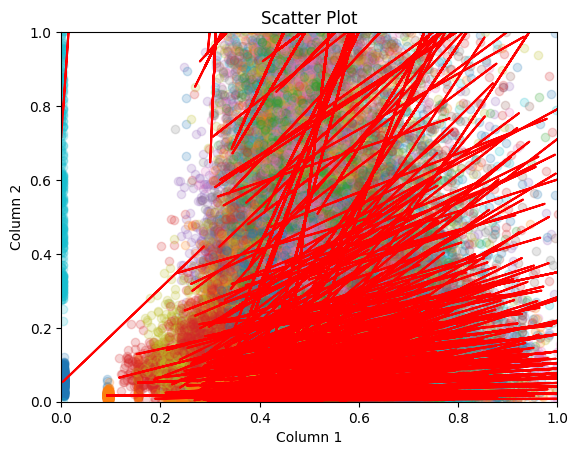

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import statistics
grouped = total_df.groupby('Collection')
# grouped = coll_to_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
pos_count = 0
neg_count = 0
total_count = 0


correlations = []
for label, group in tqdm(grouped):
    if label in rows:
        total_count+=1
        x = group['distance']
        y = group['sale_price']
        def statistic(x):  # explore all possible pairings by permuting `x`
            rs = stats.spearmanr(x, y).statistic  # ignore pvalue
            transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
            return transformed
        # try:
    
        # except:
        #     continue
        # plt.show()
        # Compute correlation coefficient and p-value
        correlation, p_value = pearsonr(x, y)
        
        # correlation, p_value = spearmanr(x,y)
        # ref = stats.permutation_test((x,), statistic, alternative='greater',permutation_type='pairings')
        if p_value<0.05 and correlation>0:
            correlations.append(correlation)
            plt.scatter(x,y,alpha=0.2)
            coefficients = np.polyfit(x, y, 1)
            line_of_best_fit = np.polyval(coefficients, x)
            # Plot the line of best fit
            plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')
            plt.title('Scatter Plot')
            plt.xlabel('Column 1')
            plt.xlim(left=0,right=1)
            plt.ylim(top=1,bottom=0)
            plt.ylabel('Column 2')
            # plt.show()
            pos_count+=1
            print(f"Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
        elif p_value<0.05 and correlation<0:
            neg_count+=1
print(total_count)
print(pos_count)
print(neg_count)
print(np.percentile(correlations,[5,25,50,75,95]))
print(np.mean(correlations))

In [ ]:
pfp_rows = df1.query(f"Collection in {rows}")
selected_columns = pfp_rows[['Contract', 'NFT_num']].to_numpy().tolist()
# rares_to_grab  = list(chunked(selected_columns,10_000))
# for rare_chunk in rares_to_grab:
#     rarities = alc.NFT_to_rarities(rare_chunk)
#     command = "INSERT INTO nft_to_rare (contract, token_id, rarity) VALUES (%s, %s, %s) returning token_id"
#     psql.batch_insert(command,rarities)

In [128]:
merged_df_rare.query("Collection=='0n1-force'").sort_values('distance')
# merged_df_rare

,Contract,NFT_num,rarity_rank,Label,Collection,sale_price,distance


In [10]:
df_filtered_rare = merged_df_rare.groupby('Collection').filter(lambda group: len(group) >= 100)
# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered_rare['Collection'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

Label counts:
Collection
bags-by-1984               591
poobs                      590
pudgypenguins              588
pablos-lol                 585
bankrupt-ftx-yacht-club    582
                          ... 
dgenmon                    102
invazers                   102
hashguise-gen-1            101
killacubs                  101
rareshoe                   100
Name: count, Length: 959, dtype: int64


In [181]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    if label in dist_slugs:
        x_1 = group['rarity_rank']
        x_2 = group['distance']
        y = group['sale_price']
        dof = dof = len(x_1)-2
        def statistic(x):  # explore all possible pairings by permuting `x`
            rs = stats.spearmanr(x, y).statistic  # ignore pvalue
            transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
            return transformed
        count+=1
        # Compute correlation coefficient and p-value
        # correlation, p_value = pearsonr(x_1, y)
        # correlation_2, p_value_2 = pearsonr(x_2, y)
        ref = stats.permutation_test((x_1,), statistic, alternative='less',permutation_type='pairings')
        correlation, p_value = spearmanr(x_1, y)
        correlation_2, p_value_2 = spearmanr(x_2, y)
        p_value = stats.permutation_test((x_1,), statistic, alternative='less',permutation_type='pairings').pvalue
        p_value_2 = stats.permutation_test((x_2,), statistic, alternative='greater',permutation_type='pairings').pvalue
        print(p_value)
        print(p_value_2)
        if np.abs(correlation)>np.abs(correlation_2) and p_value<0.05:
        # if p_value<0.05:
            if correlation<-0:
                print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
                count_rare_neg+=1
            else:
                print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
                count_rare+=1
        elif p_value_2<0.05:
            if correlation_2<0:
                count_dist_neg+=1
            else:
                count_dist+=1
print(count)
print(f"Rare: {count_rare}, Rare Neg: {count_rare_neg}, Dist: {count_dist}, Dist Neg:{count_dist_neg}")

  0%|                                           | 2/959 [00:13<1:44:30,  6.55s/it]

0.4727
0.859


  1%|▎                                            | 7/959 [00:26<55:38,  3.51s/it]

0.0368
0.0132


  1%|▎                                          | 8/959 [00:40<1:26:13,  5.44s/it]

0.3767
0.3985


  1%|▌                                         | 12/959 [00:53<1:08:55,  4.37s/it]

0.001
0.1803
(Rarity) Collection: 3l3phants-official, Correlation: -0.20602940805411732, P-Value:0.001


  2%|▋                                         | 15/959 [01:07<1:10:12,  4.46s/it]

0.1709
0.0053


  2%|▋                                         | 16/959 [01:20<1:29:59,  5.73s/it]

0.7765
0.2329


  2%|▋                                         | 17/959 [01:35<1:52:25,  7.16s/it]

0.0002
0.2574
(Rarity) Collection: 8bituniverse, Correlation: -0.1925369282285529, P-Value:0.0002


  2%|▉                                         | 20/959 [01:48<1:33:41,  5.99s/it]

0.3837
0.2256


  4%|█▋                                          | 36/959 [02:03<32:52,  2.14s/it]

0.0065
0.0001


  4%|█▋                                          | 37/959 [02:17<44:35,  2.90s/it]

0.6417
0.0002


  4%|█▊                                          | 40/959 [02:31<50:14,  3.28s/it]

0.091
0.0926


  4%|█▊                                        | 41/959 [02:44<1:04:35,  4.22s/it]

0.1061
0.0335


  5%|█▉                                        | 44/959 [02:59<1:06:53,  4.39s/it]

0.0051
0.2749
(Rarity) Collection: alleykatzofficial, Correlation: -0.12209554646566223, P-Value:0.0051


/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
  5%|██                                        | 46/959 [03:04<1:01:37,  4.05s/it]

0.0001
0.5309


  5%|██▍                                         | 52/959 [03:18<48:21,  3.20s/it]

0.0232
0.0164


  6%|██▊                                         | 60/959 [03:33<38:17,  2.56s/it]

0.0001
0.0001
(Rarity) Collection: animonkeys, Correlation: -0.2595313460220716, P-Value:0.0001


  6%|██▊                                         | 62/959 [03:48<48:49,  3.27s/it]

0.0407
0.0635
(Rarity) Collection: antonymgenesis, Correlation: -0.07721941511436112, P-Value:0.0407


  7%|██▉                                         | 64/959 [04:02<58:44,  3.94s/it]

0.0019
0.0001


  8%|███▌                                        | 79/959 [04:17<29:46,  2.03s/it]

0.0007
0.0449
(Rarity) Collection: atsui, Correlation: -0.14530428448100044, P-Value:0.0007


  8%|███▋                                        | 80/959 [04:29<38:40,  2.64s/it]

0.1836
0.0433


  9%|███▊                                        | 82/959 [04:43<46:47,  3.20s/it]

0.3248
0.0001


  9%|███▉                                        | 85/959 [04:58<52:56,  3.63s/it]

0.5293
0.2891


 10%|████▏                                       | 92/959 [05:11<41:55,  2.90s/it]

0.0001
0.0057
(Rarity) Collection: babobunnyclub, Correlation: -0.37114030845343304, P-Value:0.0001


 10%|████▎                                       | 95/959 [05:26<47:53,  3.33s/it]

0.4258
0.3944


 10%|████▍                                       | 98/959 [05:41<52:54,  3.69s/it]

0.0383
0.2035
(Rarity) Collection: baluba, Correlation: -0.0804363746839375, P-Value:0.0383


 11%|████▌                                      | 103/959 [05:55<48:22,  3.39s/it]

0.0328
0.1242
(Rarity) Collection: based-ghouls, Correlation: -0.09129863259685485, P-Value:0.0328


 11%|████▍                                    | 104/959 [06:10<1:03:25,  4.45s/it]

0.1726
0.0534


 11%|████▌                                    | 106/959 [06:25<1:11:41,  5.04s/it]

0.2856
0.2096


 12%|████▉                                      | 111/959 [06:39<58:18,  4.13s/it]

0.0002
0.0696
(Rarity) Collection: beanzofficial, Correlation: -0.16806242055979959, P-Value:0.0002


 12%|████▊                                    | 112/959 [06:53<1:13:05,  5.18s/it]

0.0001
0.0001


 12%|████▊                                    | 114/959 [07:08<1:20:32,  5.72s/it]

0.0001
0.0017
(Rarity) Collection: beartings, Correlation: -0.17771121459990782, P-Value:0.0001


 12%|████▉                                    | 116/959 [07:22<1:25:54,  6.11s/it]

0.2476
0.2623


 13%|█████▍                                     | 122/959 [07:37<58:12,  4.17s/it]

0.0002
0.0158
(Rarity) Collection: binkies, Correlation: -0.17636467715172938, P-Value:0.0002


 13%|█████▋                                     | 126/959 [07:50<54:38,  3.94s/it]

0.3652
0.4272


 13%|█████▊                                     | 129/959 [08:04<56:57,  4.12s/it]

0.0673
0.428


 15%|██████▎                                    | 142/959 [08:18<30:03,  2.21s/it]

0.0001
0.0001
(Rarity) Collection: bored-ape-comic, Correlation: -0.4722567079430092, P-Value:0.0001


 15%|██████▍                                    | 143/959 [08:32<40:31,  2.98s/it]

0.0194
0.049
(Rarity) Collection: bored-ape-kennel-club, Correlation: -0.09897199073052564, P-Value:0.0194


 15%|██████▋                                    | 148/959 [08:47<40:10,  2.97s/it]

0.0001
0.0006
(Rarity) Collection: bored-mummy-waking-up, Correlation: -0.23328933685129194, P-Value:0.0001


 16%|██████▊                                    | 152/959 [09:01<41:36,  3.09s/it]

0.1002
0.0134


 17%|███████▏                                   | 161/959 [09:14<31:27,  2.36s/it]

0.2475
0.1836


 17%|███████▍                                   | 167/959 [09:29<31:38,  2.40s/it]

0.0142
0.0049


 18%|███████▌                                   | 170/959 [09:43<36:48,  2.80s/it]

0.0112
0.0456
(Rarity) Collection: bus-stop, Correlation: -0.12150115941254017, P-Value:0.0112


 19%|████████▏                                  | 183/959 [09:57<24:49,  1.92s/it]

0.0002
0.2038
(Rarity) Collection: catbloxgenesis, Correlation: -0.16304123078239335, P-Value:0.0002


 19%|████████▎                                  | 184/959 [10:12<33:18,  2.58s/it]

0.0001
0.0622
(Rarity) Collection: catbloxpumacapsule, Correlation: -0.22515769722225434, P-Value:0.0001


 19%|████████▎                                  | 185/959 [10:25<43:23,  3.36s/it]

0.0026
0.0089
(Rarity) Collection: catc, Correlation: -0.17766117324067549, P-Value:0.0026


 19%|████████▍                                  | 187/959 [10:39<51:18,  3.99s/it]

0.9198
0.5296


 20%|████████                                 | 188/959 [10:53<1:05:03,  5.06s/it]

0.7911
0.5019


 20%|████████                                 | 189/959 [11:07<1:20:36,  6.28s/it]

0.0001
0.0037
(Rarity) Collection: cerealclub, Correlation: -0.2832885221415014, P-Value:0.0001


 20%|████████▏                                | 191/959 [11:21<1:23:24,  6.52s/it]

0.051
0.0579


 20%|████████▎                                | 193/959 [11:36<1:25:42,  6.71s/it]

0.0001
0.0311
(Rarity) Collection: chaoscityresidents, Correlation: -0.20883486019369138, P-Value:0.0001


 20%|████████▎                                | 195/959 [11:50<1:27:33,  6.88s/it]

0.8846
0.0184


 20%|████████▍                                | 196/959 [12:05<1:45:11,  8.27s/it]

0.3676
0.3637


 21%|████████▍                                | 197/959 [12:19<1:58:30,  9.33s/it]

0.0988
0.0216


 21%|████████▌                                | 200/959 [12:33<1:31:45,  7.25s/it]

0.0002
0.2619
(Rarity) Collection: childrenofukiyoofficial, Correlation: -0.17493520567373894, P-Value:0.0002


 21%|████████▋                                | 204/959 [12:47<1:09:35,  5.53s/it]

0.0001
0.3015
(Rarity) Collection: chippys-world, Correlation: -0.18736368406536535, P-Value:0.0001


 22%|█████████▎                                 | 208/959 [13:02<59:43,  4.77s/it]

0.0004
0.0007
(Rarity) Collection: chubbykaijudao, Correlation: -0.17126463244369527, P-Value:0.0004


 22%|█████████                                | 211/959 [13:17<1:00:30,  4.85s/it]

0.7523
0.7433


 22%|█████████                                | 213/959 [13:31<1:06:36,  5.36s/it]

0.0012
0.0404
(Rarity) Collection: citizenz-nft, Correlation: -0.14845860292972624, P-Value:0.0012


 23%|█████████▊                                 | 219/959 [13:46<48:57,  3.97s/it]

0.0001
0.0003
(Rarity) Collection: collectvoxtownstar, Correlation: -0.2936356072584593, P-Value:0.0001


 23%|█████████▉                                 | 221/959 [14:01<56:04,  4.56s/it]

0.3056
0.4318


 23%|█████████▍                               | 222/959 [14:14<1:09:22,  5.65s/it]

0.0943
0.0384


 23%|█████████▌                               | 223/959 [14:30<1:26:52,  7.08s/it]

0.0025
0.0001


 24%|██████████▍                                | 232/959 [14:44<42:43,  3.53s/it]

0.0001
0.0001
(Rarity) Collection: covidpunksnft, Correlation: -0.37104533326193634, P-Value:0.0001


 24%|██████████▍                                | 234/959 [14:58<49:45,  4.12s/it]

0.3356
0.3898


 25%|██████████▌                                | 236/959 [15:12<56:18,  4.67s/it]

0.0009
0.1898
(Rarity) Collection: creaturecrowd, Correlation: -0.1724511700174776, P-Value:0.0009


 25%|██████████▋                                | 239/959 [15:26<55:25,  4.62s/it]

0.0104
0.0002


 25%|██████████▉                                | 243/959 [15:41<51:39,  4.33s/it]

0.0001
0.0002
(Rarity) Collection: croakz-v2-1, Correlation: -0.2275109056411643, P-Value:0.0001


 25%|██████████▍                              | 244/959 [15:56<1:05:54,  5.53s/it]

0.6922
0.3207


 26%|██████████▌                              | 246/959 [16:09<1:08:45,  5.79s/it]

0.7913
0.0121


 26%|██████████▌                              | 248/959 [16:23<1:13:00,  6.16s/it]

0.0001
0.007
(Rarity) Collection: crypto-hobos, Correlation: -0.2645533948896932, P-Value:0.0001


 26%|██████████▋                              | 250/959 [16:37<1:14:55,  6.34s/it]

0.4181
0.3993


 26%|██████████▋                              | 251/959 [16:51<1:29:06,  7.55s/it]

0.0019
0.0291
(Rarity) Collection: crypto-pills-by-micha-klein, Correlation: -0.1578291910250709, P-Value:0.0019


 27%|███████████▍                               | 256/959 [17:05<59:04,  5.04s/it]

0.0319
0.2035
(Rarity) Collection: cryptodickbutts-s3, Correlation: -0.08651113631273727, P-Value:0.0319


 27%|███████████▌                               | 259/959 [17:19<57:10,  4.90s/it]

0.014
0.0104


 27%|███████████▏                             | 261/959 [17:34<1:03:16,  5.44s/it]

0.0001
0.0031
(Rarity) Collection: cryptoskulls, Correlation: -0.18276190729188102, P-Value:0.0001


 27%|███████████▏                             | 262/959 [17:48<1:17:11,  6.64s/it]

0.4998
0.5779


 28%|████████████                               | 269/959 [18:03<46:06,  4.01s/it]

0.0002
0.0301
(Rarity) Collection: cupcatsofficial, Correlation: -0.16725638446532998, P-Value:0.0002


 28%|████████████▏                              | 271/959 [18:15<50:56,  4.44s/it]

0.4941
0.6234


 29%|████████████▎                              | 275/959 [18:28<45:18,  3.97s/it]

0.1119
0.806


 29%|████████████▍                              | 278/959 [18:40<45:36,  4.02s/it]

0.4899
0.2338


 29%|████████████▌                              | 281/959 [18:55<48:11,  4.26s/it]

0.0001
0.0001
(Rarity) Collection: deadheads, Correlation: -0.27787996557731515, P-Value:0.0001


 30%|████████████▉                              | 289/959 [19:10<33:55,  3.04s/it]

0.0001
0.0002


 30%|█████████████                              | 290/959 [19:25<45:06,  4.05s/it]

0.0009
0.3679
(Rarity) Collection: devilvalley, Correlation: -0.13519317251634624, P-Value:0.0009


 31%|█████████████▍                             | 301/959 [19:39<27:04,  2.47s/it]

0.0771
0.0714


 32%|█████████████▌                             | 303/959 [19:53<33:22,  3.05s/it]

0.0001
0.0026
(Rarity) Collection: dodofrensxyz, Correlation: -0.22015760406257515, P-Value:0.0001


 32%|█████████████▋                             | 304/959 [20:08<44:11,  4.05s/it]

0.0001
0.0002
(Rarity) Collection: dogeclub-dogc, Correlation: -0.22571254764715892, P-Value:0.0001


 32%|█████████████▋                             | 305/959 [20:21<54:44,  5.02s/it]

0.0689
0.0366


 32%|█████████████▋                             | 306/959 [20:26<55:26,  5.09s/it]

0.0001
0.0652


 32%|█████████████▏                           | 307/959 [20:41<1:11:41,  6.60s/it]

0.0001
0.0118
(Rarity) Collection: donald-trump-yacht-club, Correlation: -0.1986718335182368, P-Value:0.0001


 32%|█████████████▏                           | 308/959 [20:54<1:25:51,  7.91s/it]

0.0057
0.0123
(Rarity) Collection: doodlefrensnft, Correlation: -0.14647017742554147, P-Value:0.0057


 32%|█████████████▏                           | 309/959 [21:09<1:41:48,  9.40s/it]

0.0005
0.0085
(Rarity) Collection: doodles-official, Correlation: -0.15944327909143075, P-Value:0.0005


 33%|█████████████▎                           | 312/959 [21:24<1:18:43,  7.30s/it]

0.0003
0.2082
(Rarity) Collection: dotdotdots, Correlation: -0.1372007559733921, P-Value:0.0003


 33%|██████████████▏                            | 316/959 [21:38<58:53,  5.50s/it]

0.0006
0.0511
(Rarity) Collection: dragon-town-wtf, Correlation: -0.16887396846730915, P-Value:0.0006


 33%|██████████████▎                            | 319/959 [21:53<56:37,  5.31s/it]

0.004
0.0169
(Rarity) Collection: dreamyofficial, Correlation: -0.11847424083840156, P-Value:0.004


 35%|██████████████▊                            | 331/959 [22:08<27:37,  2.64s/it]

0.186
0.2267


 35%|██████████████▉                            | 333/959 [22:22<33:36,  3.22s/it]

0.2592
0.1428


 35%|███████████████                            | 337/959 [22:36<34:10,  3.30s/it]

0.1027
0.0022


 35%|███████████████▏                           | 338/959 [22:50<44:34,  4.31s/it]

0.0053
0.0567
(Rarity) Collection: escape-the-agenda-official, Correlation: -0.12035114202454078, P-Value:0.0053


 35%|███████████████▏                           | 340/959 [23:04<49:37,  4.81s/it]

0.0802
0.2742


 36%|███████████████▎                           | 342/959 [23:18<54:53,  5.34s/it]

0.0001
0.0001


 36%|███████████████▌                           | 348/959 [23:32<38:45,  3.81s/it]

0.2127
0.0296


 36%|███████████████▋                           | 350/959 [23:45<44:35,  4.39s/it]

0.6314
0.028


 37%|███████████████▊                           | 354/959 [24:00<41:12,  4.09s/it]

0.3797
0.0429


 37%|███████████████▉                           | 355/959 [24:13<51:41,  5.13s/it]

0.508
0.3599


 38%|████████████████▍                          | 367/959 [24:26<24:23,  2.47s/it]

0.005
0.098
(Rarity) Collection: fiveheadcircle, Correlation: -0.1967562381743792, P-Value:0.005


 39%|████████████████▋                          | 373/959 [24:40<23:31,  2.41s/it]

0.0001
0.4964
(Rarity) Collection: fluf-world-thingies, Correlation: -0.24641448526457038, P-Value:0.0001


 39%|████████████████▊                          | 374/959 [24:54<31:28,  3.23s/it]

0.5296
0.2313


 39%|████████████████▊                          | 375/959 [25:08<41:40,  4.28s/it]

0.1118
0.652


 40%|████████████████▉                          | 379/959 [25:23<39:00,  4.04s/it]

0.0001
0.0006
(Rarity) Collection: foxyfamnft, Correlation: -0.19412616236951155, P-Value:0.0001


 40%|█████████████████                          | 380/959 [25:37<49:29,  5.13s/it]

0.0059
0.6036
(Rarity) Collection: fragments-by-james-jean, Correlation: -0.1317089114825086, P-Value:0.0059


 40%|████████████████▎                        | 381/959 [25:52<1:02:34,  6.50s/it]

0.6178
0.1919


 40%|████████████████▎                        | 382/959 [26:05<1:12:43,  7.56s/it]

0.8737
0.0819


 40%|████████████████▍                        | 384/959 [26:20<1:11:49,  7.50s/it]

0.0001
0.5404
(Rarity) Collection: fresh-fools-nft, Correlation: -0.2129476244029511, P-Value:0.0001


 40%|█████████████████▎                         | 387/959 [26:25<49:03,  5.15s/it]

0.0001
0.3899


 41%|█████████████████▍                         | 389/959 [26:39<54:37,  5.75s/it]

0.0564
0.0361


 41%|█████████████████▌                         | 391/959 [26:53<57:47,  6.11s/it]

0.1944
0.1897


 41%|████████████████▊                        | 393/959 [27:08<1:00:31,  6.42s/it]

0.0085
0.0481
(Rarity) Collection: funclesnft, Correlation: -0.11889595778783318, P-Value:0.0085


 41%|█████████████████▊                         | 397/959 [27:22<48:33,  5.18s/it]

0.0704
0.0165


 42%|█████████████████▉                         | 399/959 [27:36<52:13,  5.60s/it]

0.0031
0.0073
(Rarity) Collection: galactic-secret-agency, Correlation: -0.16415990011731174, P-Value:0.0031


 42%|██████████████████                         | 404/959 [27:51<40:39,  4.40s/it]

0.1023
0.5953


 42%|██████████████████▏                        | 405/959 [28:05<51:05,  5.53s/it]

1.0
0.9483


 42%|█████████████████▎                       | 406/959 [28:20<1:03:05,  6.84s/it]

0.051
0.3349


 43%|██████████████████▎                        | 409/959 [28:35<56:19,  6.14s/it]

0.0871
0.0428


 43%|█████████████████▌                       | 410/959 [28:49<1:07:32,  7.38s/it]

0.0001
0.0049
(Rarity) Collection: gen-dot-art, Correlation: -0.24209079020548152, P-Value:0.0001


 43%|██████████████████▌                        | 415/959 [29:03<44:31,  4.91s/it]

0.7768
0.032


 43%|██████████████████▋                        | 417/959 [29:18<49:57,  5.53s/it]

0.0028
0.0001


 44%|█████████████████▊                       | 418/959 [29:33<1:02:08,  6.89s/it]

0.0031
0.6475
(Rarity) Collection: ghostchildbones, Correlation: -0.1140810626628119, P-Value:0.0031


 44%|██████████████████▉                        | 422/959 [29:47<48:24,  5.41s/it]

0.0414
0.8908
(Rarity) Collection: gitcoin-presents, Correlation: -0.08301177079818037, P-Value:0.0414


 45%|███████████████████▏                       | 429/959 [30:02<32:21,  3.66s/it]

0.2309
0.1085


 45%|███████████████████▎                       | 432/959 [30:15<33:53,  3.86s/it]

0.2923
0.1509


 45%|███████████████████▍                       | 433/959 [30:29<43:08,  4.92s/it]

0.0002
0.0031
(Rarity) Collection: gossamer-academy, Correlation: -0.19061707839033687, P-Value:0.0002


 45%|███████████████████▍                       | 434/959 [30:44<54:24,  6.22s/it]

1.0
0.1067


 45%|██████████████████▌                      | 435/959 [30:57<1:02:42,  7.18s/it]

0.5728
0.0096


 46%|███████████████████▋                       | 438/959 [31:11<53:39,  6.18s/it]

0.0003
0.0001


 46%|███████████████████▊                       | 441/959 [31:25<48:22,  5.60s/it]

0.1271
0.1707


 47%|████████████████████                       | 448/959 [31:39<31:05,  3.65s/it]

0.0059
0.0001


 47%|████████████████████▏                      | 450/959 [31:53<36:30,  4.30s/it]

0.5438
0.2423


 47%|████████████████████▎                      | 453/959 [32:08<37:45,  4.48s/it]

0.6328
0.3048


 48%|████████████████████▍                      | 456/959 [32:22<38:19,  4.57s/it]

0.4298
0.2374


 48%|████████████████████▍                      | 457/959 [32:35<46:12,  5.52s/it]

0.9262
0.1605


 48%|████████████████████▌                      | 458/959 [32:49<56:53,  6.81s/it]

0.0001
0.0002
(Rarity) Collection: hausphasesbyfabrik, Correlation: -0.19757046879299853, P-Value:0.0001


 48%|████████████████████▊                      | 463/959 [33:03<38:55,  4.71s/it]

1.0
0.002


 48%|████████████████████▊                      | 465/959 [33:17<43:23,  5.27s/it]

0.0001
0.0303
(Rarity) Collection: himalayainc, Correlation: -0.3530329325857317, P-Value:0.0001


 49%|████████████████████▉                      | 466/959 [33:30<52:21,  6.37s/it]

0.3472
0.3582


 49%|█████████████████████                      | 469/959 [33:44<46:24,  5.68s/it]

0.0001
0.0078
(Rarity) Collection: hot-dougs, Correlation: -0.23414665156206793, P-Value:0.0001


 49%|█████████████████████                      | 471/959 [33:58<48:56,  6.02s/it]

0.038
0.1262
(Rarity) Collection: hugpass, Correlation: -0.09811459460555026, P-Value:0.038


 49%|█████████████████████▎                     | 474/959 [34:11<44:16,  5.48s/it]

0.3531
0.0613


 51%|█████████████████████▋                     | 485/959 [34:25<21:32,  2.73s/it]

0.7992
0.7677


 51%|█████████████████████▊                     | 487/959 [34:38<25:28,  3.24s/it]

0.1643
0.1785


 51%|█████████████████████▉                     | 488/959 [34:52<33:44,  4.30s/it]

0.1002
0.1618


 52%|██████████████████████▏                    | 496/959 [35:05<22:14,  2.88s/it]

0.0027
0.0001


 52%|██████████████████████▎                    | 499/959 [35:18<24:45,  3.23s/it]

0.2989
0.269


 52%|██████████████████████▌                    | 502/959 [35:32<27:00,  3.55s/it]

0.0008
0.0001


 52%|██████████████████████▌                    | 503/959 [35:46<35:21,  4.65s/it]

0.37
0.0249


 53%|██████████████████████▋                    | 505/959 [36:00<38:38,  5.11s/it]

0.203
0.1207


 53%|██████████████████████▊                    | 509/959 [36:13<33:15,  4.43s/it]

0.0008
0.0006


 53%|██████████████████████▉                    | 512/959 [36:27<33:07,  4.45s/it]

0.5289
0.5793


 54%|███████████████████████▏                   | 517/959 [36:39<26:46,  3.64s/it]

0.9857
0.1302


 55%|███████████████████████▍                   | 523/959 [36:54<22:39,  3.12s/it]

0.0007
0.0167
(Rarity) Collection: knights-of-degen-official, Correlation: -0.15416079012678854, P-Value:0.0007


 55%|███████████████████████▋                   | 528/959 [37:08<21:47,  3.03s/it]

0.0585
0.3072


 55%|███████████████████████▋                   | 529/959 [37:21<27:59,  3.90s/it]

0.3381
0.149


 56%|████████████████████████                   | 537/959 [37:35<20:06,  2.86s/it]

0.2995
0.0228


 57%|████████████████████████▎                  | 542/959 [37:49<19:22,  2.79s/it]

0.4541
0.2665


 57%|████████████████████████▍                  | 546/959 [38:04<20:58,  3.05s/it]

0.0001
0.2559
(Rarity) Collection: lilkami, Correlation: -0.1972797994987543, P-Value:0.0001


 57%|████████████████████████▌                  | 549/959 [38:17<23:06,  3.38s/it]

1.0
0.0001


 59%|█████████████████████████▎                 | 565/959 [38:31<11:43,  1.78s/it]

0.0001
0.0067
(Rarity) Collection: lostsoulssanctuary, Correlation: -0.3266168036930404, P-Value:0.0001


 59%|█████████████████████████▍                 | 568/959 [38:45<14:25,  2.21s/it]

0.0035
0.0965
(Rarity) Collection: lucky-ducky-nft, Correlation: -0.12357583514374666, P-Value:0.0035


 59%|█████████████████████████▌                 | 570/959 [38:58<17:42,  2.73s/it]

0.0535
0.0012


 60%|█████████████████████████▋                 | 574/959 [39:12<18:39,  2.91s/it]

0.4713
0.1455


 60%|█████████████████████████▊                 | 575/959 [39:26<24:37,  3.85s/it]

0.0287
0.0126


 60%|█████████████████████████▊                 | 577/959 [39:40<28:18,  4.45s/it]

0.7573
0.0235


 61%|██████████████████████████▎                | 586/959 [39:53<17:30,  2.82s/it]

0.5595
0.0994


 62%|██████████████████████████▌                | 592/959 [40:07<16:10,  2.64s/it]

0.8002
0.0277


 62%|██████████████████████████▌                | 593/959 [40:22<21:34,  3.54s/it]

0.6783
0.0016


 62%|██████████████████████████▋                | 596/959 [40:35<23:01,  3.81s/it]

0.0002
0.0008
(Rarity) Collection: metacraft-season-pass-2022, Correlation: -0.18063835918368504, P-Value:0.0002


 62%|██████████████████████████▊                | 597/959 [40:49<28:48,  4.78s/it]

0.0001
0.0001


 63%|██████████████████████████▉                | 600/959 [41:02<28:16,  4.73s/it]

0.0593
0.3366


 63%|██████████████████████████▉                | 602/959 [41:17<31:57,  5.37s/it]

0.1068
0.0962


 64%|███████████████████████████▎               | 610/959 [41:31<19:07,  3.29s/it]

0.3577
0.078


 64%|███████████████████████████▍               | 613/959 [41:45<20:37,  3.58s/it]

0.0178
0.4107
(Rarity) Collection: misfit-university-official, Correlation: -0.125566202820736, P-Value:0.0178


 64%|███████████████████████████▌               | 614/959 [41:58<25:57,  4.51s/it]

0.3822
0.4725


 64%|███████████████████████████▌               | 616/959 [42:11<28:34,  5.00s/it]

0.4293
0.3224


 64%|███████████████████████████▋               | 617/959 [42:25<35:10,  6.17s/it]

0.0001
0.0001
(Rarity) Collection: mobs-and-aliens, Correlation: -0.40931386944800563, P-Value:0.0001


 65%|███████████████████████████▉               | 622/959 [42:38<25:17,  4.50s/it]

0.6396
0.0997


 65%|███████████████████████████▉               | 623/959 [42:53<31:56,  5.70s/it]

0.057
0.2017


 65%|████████████████████████████▏              | 628/959 [43:06<23:41,  4.29s/it]

0.0161
0.0053


 66%|████████████████████████████▏              | 630/959 [43:21<27:25,  5.00s/it]

0.0068
0.0619
(Rarity) Collection: moonrunnersnft, Correlation: -0.10344136609382007, P-Value:0.0068


 66%|████████████████████████████▌              | 637/959 [43:36<18:49,  3.51s/it]

0.2898
0.3336


 67%|████████████████████████████▌              | 638/959 [43:50<23:57,  4.48s/it]

0.0003
0.0002


 67%|████████████████████████████▋              | 639/959 [44:03<29:28,  5.53s/it]

0.3331
0.2283


 67%|████████████████████████████▉              | 644/959 [44:16<22:00,  4.19s/it]

0.4864
0.1028


 67%|█████████████████████████████              | 647/959 [44:31<22:43,  4.37s/it]

0.0141
0.003


 68%|█████████████████████████████▏             | 650/959 [44:44<22:35,  4.39s/it]

0.9769
0.2185


 68%|█████████████████████████████▎             | 655/959 [44:58<18:48,  3.71s/it]

0.0001
0.5775
(Rarity) Collection: neopunkssaga, Correlation: -0.2660543326839583, P-Value:0.0001


 69%|█████████████████████████████▊             | 665/959 [45:12<12:17,  2.51s/it]

0.0004
0.011
(Rarity) Collection: noodlesnft-official, Correlation: -0.14505905642184677, P-Value:0.0004


 70%|█████████████████████████████▉             | 669/959 [45:27<13:22,  2.77s/it]

0.0002
0.0001
(Rarity) Collection: nounpunks-eth, Correlation: -0.18138296744217502, P-Value:0.0002


 71%|██████████████████████████████▍            | 680/959 [45:41<09:36,  2.07s/it]

0.1324
0.0762


 71%|██████████████████████████████▌            | 683/959 [45:55<11:17,  2.45s/it]

1.0
0.9978


 72%|██████████████████████████████▉            | 689/959 [46:08<10:48,  2.40s/it]

0.0788
0.039


 72%|██████████████████████████████▉            | 691/959 [46:23<13:26,  3.01s/it]

0.0001
0.0004
(Rarity) Collection: origamasks, Correlation: -0.21546031973641008, P-Value:0.0001


 73%|███████████████████████████████▎           | 698/959 [46:37<11:25,  2.63s/it]

0.0977
0.1355


 73%|███████████████████████████████▍           | 700/959 [46:50<13:45,  3.19s/it]

0.0005
0.006
(Rarity) Collection: peanz-official, Correlation: -0.2224232404883542, P-Value:0.0005


 75%|████████████████████████████████▏          | 718/959 [47:04<06:32,  1.63s/it]

0.999
0.1188


 75%|████████████████████████████████▏          | 719/959 [47:19<09:06,  2.28s/it]

0.0123
0.0292
(Rarity) Collection: pixels-farm, Correlation: -0.09716645065583703, P-Value:0.0123


 75%|████████████████████████████████▎          | 721/959 [47:33<11:22,  2.87s/it]

0.9997
0.0001


 75%|████████████████████████████████▍          | 724/959 [47:48<12:56,  3.30s/it]

0.6153
0.3674


 77%|████████████████████████████████▉          | 734/959 [48:02<08:49,  2.35s/it]

0.9707
0.6059


 77%|█████████████████████████████████          | 736/959 [48:16<10:53,  2.93s/it]

0.0006
0.0053
(Rarity) Collection: probablyalabel, Correlation: -0.14740663454036773, P-Value:0.0006


 77%|█████████████████████████████████▏         | 740/959 [48:31<11:27,  3.14s/it]

0.0005
0.0288
(Rarity) Collection: projectkaito, Correlation: -0.14141039546662226, P-Value:0.0005


 77%|█████████████████████████████████▎         | 743/959 [48:45<12:35,  3.50s/it]

0.0001
0.0019
(Rarity) Collection: proof-moonbirds, Correlation: -0.23005139347722764, P-Value:0.0001


 78%|█████████████████████████████████▍         | 746/959 [49:00<13:36,  3.83s/it]

0.995
0.4066


 78%|█████████████████████████████████▌         | 748/959 [49:13<15:16,  4.34s/it]

0.8197
0.6657


 78%|█████████████████████████████████▋         | 750/959 [49:26<16:44,  4.81s/it]

0.3958
0.1508


 78%|█████████████████████████████████▋         | 752/959 [49:40<18:18,  5.31s/it]

0.0164
0.014


 79%|█████████████████████████████████▊         | 755/959 [49:54<17:08,  5.04s/it]

0.0153
0.0119


 79%|█████████████████████████████████▉         | 756/959 [50:08<21:13,  6.27s/it]

0.0001
0.0023
(Rarity) Collection: purrnelopes-country-club, Correlation: -0.2042286553823599, P-Value:0.0001


 79%|█████████████████████████████████▉         | 757/959 [50:23<25:43,  7.64s/it]

0.0035
0.0032
(Rarity) Collection: pxnghostdivision, Correlation: -0.12496552942389583, P-Value:0.0035


 79%|██████████████████████████████████         | 759/959 [50:37<24:52,  7.46s/it]

0.1591
0.1142


 80%|██████████████████████████████████▏        | 763/959 [50:50<17:56,  5.49s/it]

0.0089
0.0638
(Rarity) Collection: radbro-radcats, Correlation: -0.1526211049762504, P-Value:0.0089


 80%|██████████████████████████████████▌        | 770/959 [51:04<11:22,  3.61s/it]

0.0356
0.0039


 81%|██████████████████████████████████▋        | 774/959 [51:18<11:04,  3.59s/it]

0.1375
0.0706


 81%|██████████████████████████████████▊        | 776/959 [51:32<12:44,  4.18s/it]

0.5792
0.0974


 81%|██████████████████████████████████▊        | 777/959 [51:47<16:16,  5.36s/it]

0.4271
0.1059


 81%|██████████████████████████████████▉        | 779/959 [52:01<17:25,  5.81s/it]

0.3978
0.557


 82%|███████████████████████████████████▍       | 790/959 [52:14<07:51,  2.79s/it]

1.0
0.7494


 83%|███████████████████████████████████▋       | 795/959 [52:29<07:44,  2.83s/it]

0.0007
0.0005


 83%|███████████████████████████████████▋       | 796/959 [52:43<10:06,  3.72s/it]

0.9444
0.0077


 83%|███████████████████████████████████▊       | 798/959 [52:57<11:32,  4.30s/it]

0.3232
0.4422


 83%|███████████████████████████████████▊       | 800/959 [53:11<12:49,  4.84s/it]

0.0001
0.0094
(Rarity) Collection: satoshi-island-citizenship-nfts, Correlation: -0.423630294879243, P-Value:0.0001


 84%|████████████████████████████████████       | 804/959 [53:25<11:18,  4.38s/it]

0.1821
0.0039


 84%|████████████████████████████████████       | 805/959 [53:39<14:07,  5.50s/it]

0.7434
0.9187


 85%|████████████████████████████████████▎      | 811/959 [53:52<09:29,  3.85s/it]

0.433
0.5589


 85%|████████████████████████████████████▍      | 814/959 [54:06<09:42,  4.02s/it]

0.299
0.0351


 86%|████████████████████████████████████▊      | 821/959 [54:20<07:03,  3.07s/it]

0.0001
0.0001
(Rarity) Collection: skuxxversepass, Correlation: -0.25809467350060983, P-Value:0.0001


 86%|████████████████████████████████████▉      | 823/959 [54:33<08:20,  3.68s/it]

0.0001
0.0146
(Rarity) Collection: slumdoge-billionaires, Correlation: -0.2434096301509047, P-Value:0.0001


 87%|█████████████████████████████████████▎     | 833/959 [54:48<05:12,  2.48s/it]

0.1843
0.003


 88%|█████████████████████████████████████▋     | 841/959 [55:02<04:20,  2.21s/it]

0.1357
0.6736


 88%|█████████████████████████████████████▊     | 844/959 [55:16<05:00,  2.61s/it]

0.9086
0.3323


 88%|█████████████████████████████████████▉     | 845/959 [55:29<06:28,  3.41s/it]

0.0001
0.5076
(Rarity) Collection: staxx-invaders, Correlation: -0.32166665584335813, P-Value:0.0001


 89%|██████████████████████████████████████▎    | 855/959 [55:42<04:03,  2.34s/it]

0.3669
0.0082


 90%|██████████████████████████████████████▋    | 864/959 [55:57<03:13,  2.03s/it]

0.908
0.5306


 91%|███████████████████████████████████████    | 872/959 [56:10<02:47,  1.93s/it]

0.5913
0.1448


 91%|███████████████████████████████████████▏   | 874/959 [56:24<03:28,  2.45s/it]

0.0684
0.0033


 91%|███████████████████████████████████████▏   | 875/959 [56:37<04:31,  3.23s/it]

0.049
0.0001


 92%|███████████████████████████████████████▍   | 880/959 [56:52<04:05,  3.11s/it]

0.9313
0.0001


 92%|███████████████████████████████████████▌   | 881/959 [57:07<05:23,  4.15s/it]

0.1826
0.0038


 92%|███████████████████████████████████████▋   | 885/959 [57:20<04:46,  3.87s/it]

0.0291
0.0355
(Rarity) Collection: the-sevens--companions, Correlation: -0.12617808023863122, P-Value:0.0291


 93%|███████████████████████████████████████▉   | 890/959 [57:34<04:00,  3.48s/it]

0.0145
0.2309
(Rarity) Collection: theaces, Correlation: -0.10872943749953047, P-Value:0.0145


 93%|████████████████████████████████████████▏  | 896/959 [57:48<03:12,  3.06s/it]

0.584
0.2252


 94%|████████████████████████████████████████▏  | 897/959 [58:02<04:03,  3.93s/it]

0.8707
0.0239


 94%|████████████████████████████████████████▎  | 899/959 [58:16<04:32,  4.55s/it]

0.1184
0.3875


 96%|█████████████████████████████████████████▎ | 922/959 [58:30<00:56,  1.54s/it]

0.0001
0.0013
(Rarity) Collection: trapmonkie, Correlation: -0.24698509622354164, P-Value:0.0001


 96%|█████████████████████████████████████████▍ | 925/959 [58:44<01:06,  1.95s/it]

0.0942
0.0747


 97%|█████████████████████████████████████████▊ | 932/959 [58:57<00:52,  1.93s/it]

0.948
0.1999


 98%|██████████████████████████████████████████ | 939/959 [59:11<00:38,  1.94s/it]

0.0009
0.0018
(Rarity) Collection: waltz-sunflower, Correlation: -0.1825388899627958, P-Value:0.0009


 98%|██████████████████████████████████████████▏| 940/959 [59:24<00:48,  2.58s/it]

0.6715
0.3743


 98%|██████████████████████████████████████████▎| 944/959 [59:37<00:40,  2.71s/it]

0.7574
0.5147


 99%|██████████████████████████████████████████▋| 953/959 [59:51<00:13,  2.22s/it]

0.0001
0.0001
(Rarity) Collection: worldwidewebbland, Correlation: -0.387621800274441, P-Value:0.0001


 99%|████████████████████████████████████████▊| 954/959 [1:00:06<00:15,  3.04s/it]

0.0001
0.0001
(Rarity) Collection: writers-room, Correlation: -0.2258260281568548, P-Value:0.0001


100%|█████████████████████████████████████████| 959/959 [1:00:20<00:00,  3.78s/it]

0.1999
0.2109
260
Rare: 0, Rare Neg: 90, Dist: 66, Dist Neg:0


In [182]:
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
rare_r2s = []
dist_r2s = []
dist_slugs = []
for label, group in tqdm(grouped):
    # if label not in rows:
    x_1 = -np.asarray(group['rarity_rank'])
    x_1 = x_1.reshape(-1, 1)
    x_2 = np.asarray(group['distance'])
    x_2 = x_2.reshape(-1, 1)
    y = np.asarray(group['sale_price'])
    y = y.reshape(-1, 1)
    # y = np.log10(y, out=np.zeros_like(y), where=(y!=0))
    # Create linear regression object for rarity
    regr1 = linear_model.LinearRegression(positive=True)
    regr1.fit(x_1, y)
    rarity_pred = regr1.predict(x_1)
    # Create linear regression object for rarity
    regr2 = linear_model.LinearRegression(positive=True)
    regr2.fit(x_2, y)
    visual_pred = regr2.predict(x_2)
    # Compute correlation coefficient and p-value
    rare_r2 = r2_score(y,rarity_pred)
    # rare_r2s.append(rare_r2)
    dist_r2= r2_score(y,visual_pred)
    # dist_r2s.append(dist_r2)
    if max(rare_r2,dist_r2) ==0:
        continue
    if rare_r2>dist_r2:
        count_rare+=1
        rare_r2s.append(rare_r2)
    else:
        print(f"(Visual) Collection: {label}, R2: {dist_r2}")
        count_dist+=1
        dist_slugs.append(label)
        dist_r2s.append(dist_r2)
print(count_rare,count_dist,np.mean(rare_r2s),np.mean(dist_r2s))

  9%|███▋                                       | 83/959 [00:00<00:02, 432.43it/s]

(Visual) Collection: 0xawnft, R2: 0.0006289314612103469
(Visual) Collection: 2545bygr4y, R2: 0.06057554619828054
(Visual) Collection: 3600yako-nft, R2: 0.000744963445071023
(Visual) Collection: 3l3phants-official, R2: 0.08121097681771261
(Visual) Collection: 555-hunter-orrell, R2: 0.009047262018901936
(Visual) Collection: 8bitguyz, R2: 0.00013891234506835382
(Visual) Collection: 8bituniverse, R2: 0.1056364094909511
(Visual) Collection: 9dcc-iteration-01-looks, R2: 0.001376985317201207
(Visual) Collection: akc, R2: 0.054260122934206234
(Visual) Collection: akidcalledbeast, R2: 0.039321283605626145
(Visual) Collection: akumu-dragonz, R2: 0.016204528290649778
(Visual) Collection: akutars, R2: 0.018687636498854188
(Visual) Collection: alleykatzofficial, R2: 0.045868252466716664
(Visual) Collection: almaxjackirving-odyssey, R2: 0.00016359220977402167
(Visual) Collection: ambushofficialpowreboot, R2: 0.11235007852230727
(Visual) Collection: animonkeys, R2: 0.3871846433312389
(Visual) Collect

 20%|████████▎                                 | 189/959 [00:00<00:01, 495.84it/s]

(Visual) Collection: beanzofficial, R2: 0.05950059265293528
(Visual) Collection: bearmarketbears, R2: 0.13348905144427692
(Visual) Collection: beartings, R2: 0.1034960673488482
(Visual) Collection: bestfriend-collection, R2: 0.02549968122753643
(Visual) Collection: binkies, R2: 0.1432829158066763
(Visual) Collection: bitgoatznft, R2: 0.0011848899485589204
(Visual) Collection: blklavas, R2: 0.006663733419718376
(Visual) Collection: bored-ape-comic, R2: 0.14516322023191564
(Visual) Collection: bored-ape-kennel-club, R2: 0.0015060415622066836
(Visual) Collection: bored-mummy-waking-up, R2: 0.2098218244500234
(Visual) Collection: boredapeyogaclub, R2: 0.041831829213549776
(Visual) Collection: brycnft, R2: 0.003760098502265219
(Visual) Collection: budverse-cans-heritage-edition, R2: 0.0508377041231588
(Visual) Collection: bus-stop, R2: 0.014744434812872464
(Visual) Collection: catbloxgenesis, R2: 0.04705826366571697
(Visual) Collection: catbloxpumacapsule, R2: 0.06958189083002553
(Visual) C

 31%|████████████▉                             | 296/959 [00:00<00:01, 515.01it/s]

(Visual) Collection: collectvoxtownstar, R2: 0.15967211163751882
(Visual) Collection: commoners-by-commonopoly, R2: 0.023769343486903405
(Visual) Collection: commsaur, R2: 0.06955326969644449
(Visual) Collection: cool-cats-nft, R2: 0.012648572763340526
(Visual) Collection: covidpunksnft, R2: 0.04789726092992119
(Visual) Collection: cpg-pop, R2: 0.0029351787063703894
(Visual) Collection: creaturecrowd, R2: 0.2167951761276462
(Visual) Collection: crecodiles, R2: 0.053706441101099456
(Visual) Collection: croakz-v2-1, R2: 0.0603303825960384
(Visual) Collection: crudeborne-eggs, R2: 0.005221606484041574
(Visual) Collection: crypto-bears-by-cbs, R2: 0.013436803527214214
(Visual) Collection: crypto-hobos, R2: 0.08219046386727147
(Visual) Collection: crypto-phunks, R2: 1.3998438836759775e-05
(Visual) Collection: crypto-pills-by-micha-klein, R2: 0.045715716759073044
(Visual) Collection: cryptodickbutts-s3, R2: 0.054013258856168256
(Visual) Collection: cryptomutts-official, R2: 0.040755317767834

 42%|█████████████████▌                        | 402/959 [00:00<00:01, 520.79it/s]

(Visual) Collection: elftown-wtf, R2: 0.0019013707911690325
(Visual) Collection: elven, R2: 0.021857018366812198
(Visual) Collection: eponym, R2: 0.04452217479934806
(Visual) Collection: escape-the-agenda-official, R2: 0.05222522742797486
(Visual) Collection: ethalien-vox, R2: 0.03402001004229782
(Visual) Collection: etherealswtf, R2: 0.04179466237283014
(Visual) Collection: everythingiown, R2: 0.02447482184764249
(Visual) Collection: exclusible-alpha, R2: 0.010109523396518494
(Visual) Collection: eyesoffashionnft, R2: 0.0007257285425745774
(Visual) Collection: ezu, R2: 0.0016972166711469727
(Visual) Collection: fiveheadcircle, R2: 0.019286021328856373
(Visual) Collection: fluf-world-thingies, R2: 0.1238739163388638
(Visual) Collection: fly-frogs, R2: 0.005266455971437156
(Visual) Collection: fomo-mofos, R2: 0.055128495846828884
(Visual) Collection: foxyfamnft, R2: 0.15558353275193104
(Visual) Collection: fragments-by-james-jean, R2: 0.019439230745842973
(Visual) Collection: frankfrank

 53%|██████████████████████▏                   | 508/959 [00:01<00:00, 521.16it/s]

(Visual) Collection: great-expectations, R2: 0.08953469240260947
(Visual) Collection: grimbogs-by-bedbugs, R2: 0.01993004343492455
(Visual) Collection: gutterpigeons, R2: 0.08962934447331672
(Visual) Collection: habbo-avatars, R2: 2.8654865303456845e-05
(Visual) Collection: hapeprime, R2: 0.004458173375202157
(Visual) Collection: hasbinft, R2: 0.0034651437006054664
(Visual) Collection: hashguise-gen-1, R2: 0.004827545389313848
(Visual) Collection: hausphasesbyfabrik, R2: 0.09201620274194267
(Visual) Collection: heedongofficial, R2: 0.04638376066312622
(Visual) Collection: himalayainc, R2: 0.09165821226252535
(Visual) Collection: hiphop-reboot-official, R2: 0.015830566449134165
(Visual) Collection: hot-dougs, R2: 0.07669396394285521
(Visual) Collection: hugpass, R2: 0.10483216719409028
(Visual) Collection: idamura-xyz, R2: 0.018701458987514852
(Visual) Collection: internet-raised-official, R2: 0.015705289587978566
(Visual) Collection: invazers, R2: 0.17148173267840894
(Visual) Collectio

 64%|██████████████████████████▉               | 614/959 [00:01<00:00, 525.22it/s]

(Visual) Collection: lilkami, R2: 0.08112582366059562
(Visual) Collection: linksdao, R2: 0.6793159054043152
(Visual) Collection: lostsoulssanctuary, R2: 0.14566077730229987
(Visual) Collection: lucky-ducky-nft, R2: 0.01400090028867862
(Visual) Collection: lumilands, R2: 0.044935179923865975
(Visual) Collection: machina-the-underground, R2: 0.032378685932580864
(Visual) Collection: machine-soldier, R2: 0.05362314565340398
(Visual) Collection: magicforestnosleep, R2: 0.019760535125450174
(Visual) Collection: mcgoblinwtf, R2: 0.0030340425129752324
(Visual) Collection: meltdown-nft-official, R2: 0.003901274689205647
(Visual) Collection: memsvoyageone, R2: 0.038176342394397156
(Visual) Collection: metacraft-season-pass-2022, R2: 0.06237616072090324
(Visual) Collection: metakrew, R2: 0.11141065769730074
(Visual) Collection: metatravelers, R2: 0.030722615571511458
(Visual) Collection: mfers, R2: 0.010749837496535686
(Visual) Collection: mintge-ji-ba, R2: 0.019851585053228815
(Visual) Collecti

 75%|███████████████████████████████▌          | 721/959 [00:01<00:00, 527.59it/s]

(Visual) Collection: neopunkssaga, R2: 0.05569461748144344
(Visual) Collection: noodlesnft-official, R2: 0.001188755246316231
(Visual) Collection: nounpunks-eth, R2: 0.04897114816830972
(Visual) Collection: officialdudes, R2: 0.07179081023494549
(Visual) Collection: old-barefootparrots, R2: 0.0008860788469687852
(Visual) Collection: onitamanft, R2: 0.01182115160856545
(Visual) Collection: origamasks, R2: 0.15835804902757422
(Visual) Collection: party-penguins, R2: 0.037344580057045995
(Visual) Collection: peanz-official, R2: 0.09676616330236221
(Visual) Collection: pixelchain, R2: 0.010599640850345815
(Visual) Collection: pixels-farm, R2: 0.01849144277590975
(Visual) Collection: pixl-pets-genesis, R2: 0.00782163077425313
(Visual) Collection: planetcoco, R2: 0.0005764882482341971
(Visual) Collection: prim8, R2: 1.9677271134721508e-07
(Visual) Collection: probablyalabel, R2: 0.15341531543290132
(Visual) Collection: projectkaito, R2: 0.06127629085692976
(Visual) Collection: proof-moonbird

 86%|████████████████████████████████████▎     | 828/959 [00:01<00:00, 525.86it/s]

(Visual) Collection: radbro-radcats, R2: 0.055196426578922764
(Visual) Collection: re-genz, R2: 0.06721395319566259
(Visual) Collection: regulars, R2: 0.02569957043303217
(Visual) Collection: rektfolios, R2: 0.00039629475263580627
(Visual) Collection: rektguy, R2: 0.023590251304840493
(Visual) Collection: remilio-babies, R2: 0.015041620151210022
(Visual) Collection: rtfkt-nike-cryptokicks, R2: 0.0039080925388785825
(Visual) Collection: sacred-skulls-official, R2: 0.053692948286725994
(Visual) Collection: sakura-park, R2: 0.014844442421143356
(Visual) Collection: saplingsnft, R2: 0.02688017732114445
(Visual) Collection: satoshi-island-citizenship-nfts, R2: 0.6277886044752601
(Visual) Collection: scottie-pippen, R2: 0.01698185090285731
(Visual) Collection: secretratsociety, R2: 0.0015227809944259318
(Visual) Collection: sharkzgenesis, R2: 0.00716816016354882
(Visual) Collection: shylock, R2: 0.00885191420237974
(Visual) Collection: skuxxversepass, R2: 0.2724866278912541
(Visual) Collecti

100%|██████████████████████████████████████████| 959/959 [00:01<00:00, 513.87it/s]

(Visual) Collection: the-british, R2: 0.012249395578261879
(Visual) Collection: the-cult-club, R2: 0.0442664823509733
(Visual) Collection: the-dooplicator, R2: 0.18766871066531732
(Visual) Collection: the-phoenixes, R2: 0.078315038383869
(Visual) Collection: the-picaroons, R2: 0.005196786779386731
(Visual) Collection: the-sevens--companions, R2: 0.009215677752338225
(Visual) Collection: theaces, R2: 0.038489343802476705
(Visual) Collection: theindifferentduck, R2: 0.009012430094424206
(Visual) Collection: thelastabyss, R2: 0.02254907522343541
(Visual) Collection: thelonelyfroglamboclub, R2: 0.003202921152756777
(Visual) Collection: trapmonkie, R2: 0.024161403919424118
(Visual) Collection: tubby-cats, R2: 0.02305424219225427
(Visual) Collection: vansofficial, R2: 0.004453921140801453
(Visual) Collection: waltz-sunflower, R2: 0.014345379330071961
(Visual) Collection: wearebyjohnjohnny, R2: 0.0011079850424915438
(Visual) Collection: wgmi-studios-genesis, R2: 2.1758758967926894e-06
(Visual

In [149]:
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
rare_r2s = []
dist_r2s = []
for label, group in tqdm(grouped):
    x_1 = -np.asarray(group['rarity_rank'])
    x_1 = x_1.reshape(-1, 1)
    x_2 = np.asarray(group['distance'])
    x_2 = x_2.reshape(-1, 1)
    y = np.asarray(group['sale_price'])
    y = y.reshape(-1, 1)
    combined_array = np.hstack((x_1, x_2))
    # y = np.log10(y, out=np.zeros_like(y), where=(y!=0))
    # Create linear regression object for rarity
    regr1 = linear_model.LinearRegression()
    regr1.fit(combined_array, y)
    rarity_pred = regr1.predict(combined_array)
    # Create linear regression object for rarity
    # Compute correlation coefficient and p-value
    rare_r2 = r2_score(y,rarity_pred)
    rare_r2s.append(rare_r2)
    # dist_r2= r2_score(y,visual_pred)
    # dist_r2s.append(dist_r2)
    if rare_r2>0.1:
        count_rare+=1
    # elif regr2.coef_>0 and dist_r2>0.2:
    #     count_dist+=1
print(count_rare,np.median(rare_r2s))

100%|██████████████████████████████████████████| 959/959 [00:00<00:00, 961.57it/s]

120 0.03193737087697135


In [ ]:
with open('rarity_distance.pkl','wb') as f:
    pickle.dump(df_filtered_rare,f)

In [ ]:
with open('rarity_distance.pkl','rb') as f:
    df_filtered_rare = pickle.load(f)

In [ ]:

# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered_rare['rarity'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

In [161]:
df_filtered_rare.query("Collection=='sakura-park'").sort_values('rarity_rank')

,Contract,NFT_num,rarity_rank,Label,Collection,sale_price,distance
72841,0x82235445a7f634279e33702cc004b0fdb002fda7,2352,3,2807,sakura-park,0.132797,0.559004
72877,0x82235445a7f634279e33702cc004b0fdb002fda7,2533,4,1047,sakura-park,0.215547,0.630085
72710,0x82235445a7f634279e33702cc004b0fdb002fda7,1503,11,2807,sakura-park,0.072407,0.535397
72633,0x82235445a7f634279e33702cc004b0fdb002fda7,1135,14,2807,sakura-park,0.086008,0.567585
72758,0x82235445a7f634279e33702cc004b0fdb002fda7,1802,34,2807,sakura-park,0.068487,0.610942
...,...,...,...,...,...,...,...
72973,0x82235445a7f634279e33702cc004b0fdb002fda7,845,2638,1047,sakura-park,0.051833,0.620839
72861,0x82235445a7f634279e33702cc004b0fdb002fda7,2453,2639,2807,sakura-park,0.015725,0.493072
72882,0x82235445a7f634279e33702cc004b0fdb002fda7,2540,2640,2807,sakura-park,0.051563,0.612080
72778,0x82235445a7f634279e33702cc004b0fdb002fda7,1940,2645,1047,sakura-park,0.022200,0.494194


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    x_1 = 1-group['rarity']
    y = group['sale_price']
    # Compute correlation coefficient and p-value
    correlation, p_value = pearsonr(x_1, y)
    if p_value<0.05:
        x_1 = np.log(x_1)
        plt.scatter(x_1,y,alpha=0.2,label='Rarity')
        plt.title('Scatter Plot')
        plt.xlabel('Column 1')
        # plt.xlim(left=0,right=1)
        plt.ylabel('Column 2')
        try:
            coefficients = np.polyfit(x_1, y, 1)
            line_of_best_fit = np.polyval(coefficients, x_1)
            # Plot the line of best fit
            plt.plot(x_1, line_of_best_fit, color='red', label='Line of Best Fit')
        except:
            continue
        plt.legend()
        plt.show()
        
        count+=1
        print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")

In [ ]:
beans_df = merged_df2.query("Collection=='beanzofficial'")

In [ ]:
beans_df.sort_values(by="distance")

In [ ]:
import Openseas_Methods as opse
shit_list = []
for contract,token in tqdm(selected_columns[:10]):
    if contract in shit_list:
        continue
    rarity = opse.pull_nft_rarity(contract,token)
    if rarity is None:
        shit_list.append(contract)
    else:
        print(rarity)


In [123]:
columns_to_compare = ['Contract', 'NFT_num']

# Merge DataFrames based on specified columns
merged_df = pd.merge(total_df, df_rare, on=columns_to_compare, how='outer', indicator=True)

# Filter rows that are only in df1
coll_to_rare = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
coll_to_rare

,Label,Collection,NFT_num,Contract,sale_price,distance,rarity_rank
0,0,0-project,102,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.096525,0.490676,NaN
1,0,0-project,103,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.038415,0.368442,NaN
2,0,0-project,104,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.034688,0.512769,NaN
3,0,0-project,106,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.022950,0.542099,NaN
4,0,0-project,108,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.035188,0.482177,NaN
...,...,...,...,...,...,...,...
468341,3413,yeetsnft,91,0x4b13e4107b62cdcb96e0ad84ad4bc2f684440d13,0.008457,0.530718,NaN
468342,3413,yeetsnft,917,0x4b13e4107b62cdcb96e0ad84ad4bc2f684440d13,0.008788,0.440329,NaN
468343,3413,yeetsnft,92,0x4b13e4107b62cdcb96e0ad84ad4bc2f684440d13,0.009104,0.419018,NaN
468344,3413,yeetsnft,930,0x4b13e4107b62cdcb96e0ad84ad4bc2f684440d13,0.018211,0.454962,NaN


In [ ]:
selected_columns = sorted(coll_to_rare[['Contract', 'NFT_num']].to_numpy().tolist())
command = "INSERT INTO nft_to_rarity_2 (contract, token_id, rare_score, rank) VALUES (%s, %s, %s,%s) returning token_id"
rares_to_grab  = list(chunked(selected_columns,5000))
rarities = []
print(len(rares_to_grab))
bad_contracts = []
for rare_chunk in rares_to_grab[1:]:
    for contract,token_id in tqdm(rare_chunk):
        if contract in bad_contracts:
            continue
        rare_dict = opse.pull_nft_rarity(contract,token_id)
        if rare_dict is None:
            bad_contracts.append(contract)
            continue
        rarities.append((contract,token_id,rare_dict.get('score',''),rare_dict.get('rank',-1)))
    psql.batch_insert(command,rarities)
    rarities = []

65


 63%|█████████████████████████▋               | 3133/5000 [07:26<06:46,  4.59it/s]

error
<Response [429]>


  8%|███▏                                    | 404/5000 [02:37<1:04:50,  1.18it/s]

error
<Response [524]>


 85%|██████████████████████████████████▋      | 4237/5000 [09:38<02:12,  5.77it/s]

In [126]:
print('poo')

poo


In [ ]:
https://www.openrarity.dev/

  0%|                                                     | 0/959 [00:00<?, ?it/s]/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
 10%|████▏                                      | 92/959 [00:00<00:01, 479.17it/s]

Collection: 0xapes-trilogy, Correlation: 0.14478009187835955, P-Value:0.0009843014819011014
Collection: 1928-apes, Correlation: 0.14124270544246548, P-Value:0.024655838356120733
Collection: 199x-spectra, Correlation: 0.17051995026025848, P-Value:0.004802095906909498
Collection: 2545bygr4y, Correlation: 0.24612099910060645, P-Value:0.0001427018162294507
Collection: 3gm-bot-pass, Correlation: 0.09214002673425808, P-Value:0.04362069808219986
Collection: 3l3phants-official, Correlation: 0.28497539686385676, P-Value:4.479243226606441e-06
Collection: 8bituniverse, Correlation: 0.32501755258901166, P-Value:1.337735628272015e-10
Collection: 8sian-main-collection, Correlation: 0.20626667820946787, P-Value:6.241109732483508e-06
Collection: a-common-place, Correlation: 0.12036875571472969, P-Value:0.028796244864181572
Collection: abstractars, Correlation: 0.1319439415960449, P-Value:0.017317235289224433
Collection: acrocspacecraft, Correlation: 0.20500222855285544, P-Value:0.0034258409365693627
C

 22%|█████████▎                                | 213/959 [00:00<00:01, 554.73it/s]

Collection: blockydoge3, Correlation: 0.1181848748577377, P-Value:0.03946002507519574
Collection: bokinftofficial, Correlation: 0.09088640270218051, P-Value:0.03018156968669476
Collection: bonsai-zenft, Correlation: 0.2532281372075474, P-Value:1.8307738066679469e-06
Collection: boonjiproject, Correlation: 0.09220532086384463, P-Value:0.04884702029757449
Collection: bored-and-dangerous, Correlation: 0.18949839413953892, P-Value:0.002107483471015604
Collection: bored-ape-comic, Correlation: 0.381002913679037, P-Value:1.1868591397186473e-10
Collection: bored-ape-seeks-yacht-club-issue-0, Correlation: 0.4181701904233452, P-Value:2.9602836248131265e-14
Collection: bored-mummy-waking-up, Correlation: 0.45806312277897215, P-Value:9.087317829539742e-28
Collection: boredaiclub, Correlation: 0.1780700190166469, P-Value:0.003098603093115929
Collection: boredapeyogaclub, Correlation: 0.20452830907615185, P-Value:0.0002464077416865041
Collection: boredgorillayachtclub, Correlation: 0.18257198038011

 36%|██████████████▉                           | 341/959 [00:00<00:01, 601.65it/s]

Collection: cryptoadpunks, Correlation: 0.15447989688847671, P-Value:0.00547018820396732
Collection: cryptobatz-by-ozzy-osbourne, Correlation: 0.23681802457006096, P-Value:1.6166847649930403e-07
Collection: cryptocannabisclub, Correlation: 0.12182218573361506, P-Value:0.007731330413621874
Collection: cryptodickbutts-s3, Correlation: 0.23240752753765984, P-Value:5.370422945263248e-07
Collection: cryptomutts-official, Correlation: 0.201879463462321, P-Value:0.00023827897376498363
Collection: cubemindwave, Correlation: 0.44137705208303674, P-Value:1.8768346720338475e-18
Collection: cupcatsofficial, Correlation: 0.21483398165012121, P-Value:6.901743584933614e-07
Collection: darkflex, Correlation: 0.12944487690942458, P-Value:0.002604397411405629
Collection: deaddegens, Correlation: 0.2418460383917964, P-Value:6.980260292895455e-09
Collection: deadheads, Correlation: 0.24107175897990374, P-Value:6.568080223341339e-08
Collection: degenerate-regenerate, Correlation: 0.17703248149941803, P-Val

 49%|████████████████████▊                     | 474/959 [00:00<00:00, 630.84it/s]

Collection: fuekinft, Correlation: 0.15004199112186578, P-Value:0.005294657896230718
Collection: funclesnft, Correlation: 0.19205806657122487, P-Value:9.096841485868706e-05
Collection: futr-one, Correlation: 0.16253542128482693, P-Value:0.00020029845628949212
Collection: g00p, Correlation: 0.19888692456599608, P-Value:2.592194057270529e-06
Collection: galactic-secret-agency, Correlation: 0.3674756343886702, P-Value:7.311017866031778e-11
Collection: galaxy-warriors-9999, Correlation: 0.15845619340018532, P-Value:0.009104127956582107
Collection: galaxyeggs9999, Correlation: 0.15565185193887007, P-Value:0.00028627452095594244
Collection: gardenlockdown, Correlation: 0.3489127694105728, P-Value:9.395667989314067e-08
Collection: gauntlets, Correlation: 0.17864337757334023, P-Value:0.0006060493554030607
Collection: gdrake, Correlation: 0.12881161108983796, P-Value:0.0033460913630371644
Collection: gen-dot-art, Correlation: 0.40667629983740844, P-Value:9.498257794955839e-20
Collection: gh0stl

 64%|██████████████████████████▋               | 610/959 [00:01<00:00, 488.67it/s]

Collection: jpunks-og-rex, Correlation: 0.17123799794565397, P-Value:0.00367605918388702
Collection: just-mallards, Correlation: 0.389650596120878, P-Value:3.4336403674316813e-13
Collection: justcubesnft, Correlation: 0.11841552882912562, P-Value:0.01085543252770858
Collection: karafuru, Correlation: 0.11092109685477171, P-Value:0.010385800396685256
Collection: karafuru-gachapon, Correlation: 0.14270404026247935, P-Value:0.0323870638245952
Collection: karafuru-x-hypebeast-x-atmos, Correlation: 0.23769276131170744, P-Value:0.000497280866499304
Collection: kawaiimetacollage, Correlation: 0.28656547359698215, P-Value:1.2350631084883067e-06
Collection: kawamii, Correlation: 0.12741627897974236, P-Value:0.01223013607595105
Collection: khuga-by-khuga-labs, Correlation: 0.09738902672236639, P-Value:0.020709937753466894
Collection: kibatsu-mecha, Correlation: 0.14051423372677518, P-Value:0.005378988658330423
Collection: knights-of-degen-official, Correlation: 0.4026229498047458, P-Value:7.7391

 79%|█████████████████████████████████         | 756/959 [00:01<00:00, 595.84it/s]

Collection: muribyfabrik, Correlation: 0.15960247137034497, P-Value:0.00029202590425665676
Collection: mystery-bowl, Correlation: 0.11789050880819926, P-Value:0.011757718661701043
Collection: mysticsuniverse, Correlation: 0.13135763477476908, P-Value:0.047574712412736746
Collection: nakamigos, Correlation: 0.09296498615083523, P-Value:0.03015817679638883
Collection: neopunkssaga, Correlation: 0.23599707091708422, P-Value:3.2293458764536685e-05
Collection: never-fear-truth-by-jd, Correlation: 0.13244296597704253, P-Value:0.042516325946051634
Collection: nftsensei, Correlation: 0.3348780167925809, P-Value:2.7949195093866195e-12
Collection: not-a-nft-project, Correlation: 0.19182090618353714, P-Value:6.000751695224511e-06
Collection: nounpunks-eth, Correlation: 0.22129425697091568, P-Value:2.6318768172757586e-06
Collection: nyolings, Correlation: 0.10820985892692525, P-Value:0.008985882188597303
Collection: obitsofficial, Correlation: 0.09997831960582892, P-Value:0.021707098568597875
Coll

 94%|███████████████████████████████████████▎  | 897/959 [00:01<00:00, 621.77it/s]

Collection: sakura-park, Correlation: 0.12183777091338784, P-Value:0.01795091668781913
Collection: saplingsnft, Correlation: 0.16395175302858003, P-Value:0.004901023823527742
Collection: satoshi-island-citizenship-nfts, Correlation: 0.7923311204763197, P-Value:1.419374937789992e-69
Collection: scottie-pippen, Correlation: 0.13031443090792935, P-Value:0.006494364901582138
Collection: seizonofficial, Correlation: 0.11040415805287697, P-Value:0.014082651752674471
Collection: shellzorb, Correlation: 0.15071960919377655, P-Value:0.0013765854352423299
Collection: shroomios, Correlation: 0.0971279565446149, P-Value:0.04640562774835315
Collection: skuxxversepass, Correlation: 0.5220025171311474, P-Value:1.3440815059834701e-27
Collection: slumdoge-billionaires, Correlation: 0.15374675433012833, P-Value:0.00743541727545787
Collection: smashverse, Correlation: 0.2018901168947194, P-Value:0.0002843474471514867
Collection: somethingtoken, Correlation: 0.34451542967621973, P-Value:1.953854663807384e

100%|██████████████████████████████████████████| 959/959 [00:01<00:00, 567.81it/s]


Collection: unemployables, Correlation: 0.23854019182798153, P-Value:2.130158613788841e-08
Collection: unpunksnft, Correlation: 0.14643162164088727, P-Value:0.0027552892641149133
Collection: veefriends-series-2, Correlation: 0.21020921624941893, P-Value:0.002364909291923712
Collection: vogu, Correlation: 0.1937183955483287, P-Value:3.58701366382412e-05
Collection: voodoosclub, Correlation: 0.19235183448035428, P-Value:0.0011003359841410896
Collection: waltz-sunflower, Correlation: 0.11977219765067275, P-Value:0.0333083365794904
Collection: weathereportofficial, Correlation: 0.14003053333600995, P-Value:0.005021015773499418
Collection: wildpepe, Correlation: 0.23563837030280216, P-Value:4.2127267010990526e-06
Collection: woodies-generative, Correlation: 0.12045569331269121, P-Value:0.03096019569007573
Collection: worldwidewebbland, Correlation: 0.5388791560024822, P-Value:1.2529597182478765e-38
Collection: writers-room, Correlation: 0.3632800497724043, P-Value:1.2311823463433827e-17
Col

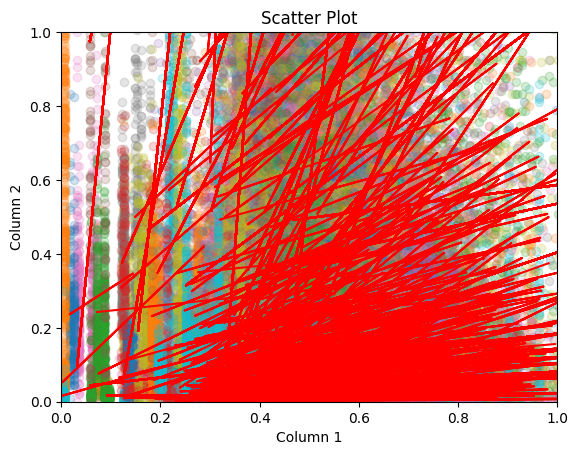

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import statistics
grouped = df_filtered_rare.groupby('Collection')
# grouped = coll_to_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
pos_count = 0
neg_count = 0
total_count = 0


correlations = []
for label, group in tqdm(grouped):
# if label in rows:
    total_count+=1
    x = group['distance']
    y = group['sale_price']
    def statistic(x):  # explore all possible pairings by permuting `x`
        rs = stats.spearmanr(x, y).statistic  # ignore pvalue
        transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
        return transformed
    # try:

    # except:
    #     continue
    # plt.show()
    # Compute correlation coefficient and p-value
    correlation, p_value = pearsonr(x, y)
    
    # correlation, p_value = spearmanr(x,y)
    # ref = stats.permutation_test((x,), statistic, alternative='greater',permutation_type='pairings')
    if p_value<0.05 and correlation>0:
        correlations.append(correlation)
        plt.scatter(x,y,alpha=0.2)
        coefficients = np.polyfit(x, y, 1)
        line_of_best_fit = np.polyval(coefficients, x)
        # Plot the line of best fit
        plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')
        plt.title('Scatter Plot')
        plt.xlabel('Column 1')
        plt.xlim(left=0,right=1)
        plt.ylim(top=1,bottom=0)
        plt.ylabel('Column 2')
        # plt.show()
        pos_count+=1
        print(f"Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
    elif p_value<0.05 and correlation<0:
        neg_count+=1
print(total_count)
print(pos_count)
print(neg_count)
print(np.percentile(correlations,[5,25,50,75,95]))
print(np.mean(correlations))